In [5]:
import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import func_pytorch as functions
from opt_traj import FR_algorithm

import torch
import pickle
import matplotlib.pyplot as plt
from pylab import figure, cm
import random
seed=50
random.seed(seed)

goal='sync'
bifurcation='high'
noise_strength= 0.0 
realizations=1
noise=0
parameters = functions.set_parameters(goal,bifurcation,parentDir)

# 10 nodes
n_nodes = 10
A = parameters['A'][:n_nodes,:n_nodes]
#A = np.zeros((5,5))
parameters['A'] = A
parameters['N'] = n_nodes


#Set dimensions
T= 400 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#set paraeters of the cost functional
I_p_in= 0.0005 #penalize precision
I_e= 1.0 #penalize control energy should be >0
I_s= 0.0#enforce sparsity

switchfromto='none'
I_p=I_p_in

#choose initial condition for control
control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

def set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise):

    #unpack parameters
    alpha=parameters['alpha']
    beta=parameters['beta']
    gamma=parameters['gamma']
    delta=parameters['delta']
    epsilon=parameters['epsilon']
    tau=parameters['tau']
    sigma=parameters['sigma']
    mu=parameters['mu']
    A=parameters['A']
    N=parameters['N']

    #set random initials on circle with set amplitudes
    if bifurcation=='low':
        ini_y=torch.rand(N)/2+0.1
        ini_z=torch.rand(N)/5+.5
    elif bifurcation=='high':
        ini_y=torch.rand(N)
        ini_z=torch.rand(N)*0.3+1.0
    
    ini_transient=torch.stack((ini_y, ini_z)).transpose(0, 1)
    ini_transient=ini_transient.reshape(2,N)
    #print(ini_transient)

    return ini_transient

node_ic=functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise)
#ic_state_high=functions.set_random_initial_conds_for_nodes('high',noise_strength,tsteps,d,dt,parameters_high,realizations,noise)
target_output=torch.ones((parameters['N'],parameters['N']))

args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)

In [6]:
def create_plot(data,ylabel,title):
    fs=30 #fontsize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    # set min and max for scope of y-axis
    minn=torch.min(data)
    maxx=torch.max(data)
    add=(maxx-minn)/25

    im1=ax.plot(torch.arange(0,int(T),dt),data)
    ax.set_xlabel('t',size=fs)
    ax.set_ylabel(ylabel,size=fs)
    ax.set_ylim(minn-add,maxx+add)
    ax.set_title(title,size=fs, pad=20)
    ax.tick_params(labelsize=fs)
    ax.grid(True)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    return fig.tight_layout()

In [7]:
nocontrol=torch.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

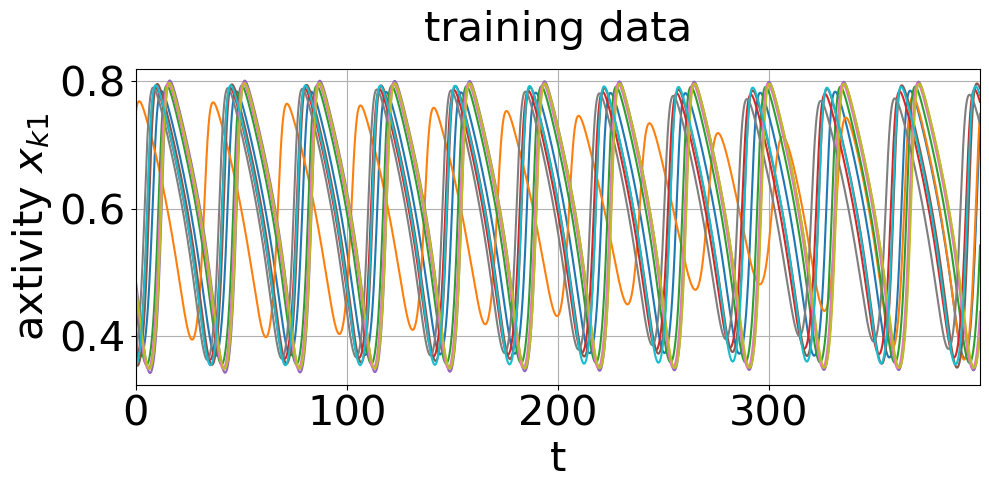

In [8]:
create_plot(state_uncontrolled[:,0,:],'axtivity $x_{k1}$','training data')
plt.show()

In [9]:
adj = torch.ones(n_nodes,n_nodes)
torch.diagonal(adj, 0).zero_()
edge_index = adj.nonzero().t().contiguous()
edge_attr = A[edge_index[0], edge_index[1]]

In [10]:
import torch
from torch import nn
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.utils import scatter
from torch_geometric.nn import MetaLayer

In [11]:
class EdgeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, src, dst, edge_attr,u=None,batch=None):
        # src, dst: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        #if edge_attr.dim() == 1:
            #edge_attr = edge_attr.view(-1, 1)
        #print(dst[:,0,:].shape,edge_attr.shape)
        #print(dst[:,0].shape,edge_attr.shape)
        for i in range(look_back):
            dst[:,0,i] = dst[:,0,i] * edge_attr
        dst = dst.contiguous().view(dst.size(0), -1)
        return dst

class NodeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        in_channels = 4*look_back
        hiddens = in_channels*2
        self.node_mlp_1 = Sequential(
            nn.Linear(in_channels, hiddens),
            nn.ReLU(),
            nn.Linear(hiddens, 2*hiddens),
            nn.ReLU(),
            nn.Linear(2*hiddens, in_channels))
        num_node_features = 2*look_forward
        self.node_mlp_2 = Sequential(
            nn.Linear(6*look_back, 2*hiddens),
            nn.ReLU(),
            nn.Linear(2*hiddens, num_node_features))

    def forward(self, x, edge_index, edge_attr,u=None,batch=None):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        x = x.contiguous().view(x.size(0), -1)
        #print(x[row].shape,edge_attr.shape)
        out = torch.cat([x[row], edge_attr], dim=1)
        #out = out.view(out.size(0), -1)
        out = self.node_mlp_1(out)
        out = scatter(out, col, dim=0, dim_size=x.size(0),
                      reduce='mean')
        out = torch.cat([x, out], dim=1)
        out = self.node_mlp_2(out)
        out = out.view(n_nodes, 2, look_forward)
        return out

In [15]:
class EdgeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, src, dst, edge_attr,u=None,batch=None):
        # src, dst: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        #if edge_attr.dim() == 1:
            #edge_attr = edge_attr.view(-1, 1)
        #print(dst[:,0,:].shape,edge_attr.shape)
        #print(dst[:,0].shape,edge_attr.shape)
        dst[:,0] = dst[:,0] * edge_attr
        

        return dst

class NodeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        in_channels = 4
        hiddens = 8
        self.node_mlp_1 = Sequential(
            nn.Linear(in_channels, hiddens),
            nn.ReLU(),
            nn.Linear(hiddens, 2*hiddens),
            nn.ReLU(),
            nn.Linear(2*hiddens, in_channels))
        in_2 = 2
        num_node_features = 2
        self.node_mlp_2 = Sequential(
            nn.Linear(in_channels+in_2, 2*hiddens),
            nn.ReLU(),
            nn.Linear(2*hiddens, num_node_features))

    def forward(self, x, edge_index, edge_attr,u=None,batch=None):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        #print(x[row].shape,edge_attr.shape)
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        #print(out.shape)
        out = scatter(out, col, dim=0, dim_size=x.size(0),
                      reduce='mean')
        #print(x.shape,out.shape)
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
model.load_state_dict(torch.load('metalayer_10_high_cc'))

<All keys matched successfully>

In [17]:
model.eval()
data = state_uncontrolled.to(device)
pred_traj = torch.zeros(data.shape[0],2,10)
pred_traj[0,:,:] = data[0,:,:]
for i in range(data.shape[0]-1):
    x = data[i,:,:].T
    pred = model(x,edge_index,edge_attr)[0]
    pred_traj[i+1,:,:] = pred.T

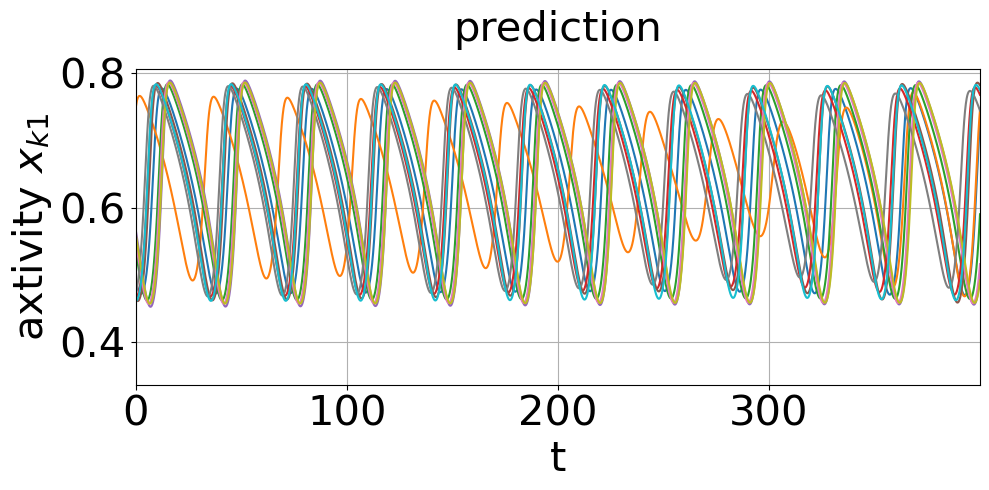

In [18]:
create_plot(pred_traj[:,0,:].detach(),'axtivity $x_{k1}$','prediction')

In [ ]:
    state = torch.zeros(tsteps,2,N)
    state[0,:,:] = traj[0,:,:]
    for i in range(tsteps-1):
        x = traj[i,:,:].T
        pred = model(x,edge_index,edge_attr)[0]
        state[i+1,:,:] = pred.T
        
    state = traj
    state = state[:,0,:]+control

In [78]:
def cross_correlation_matrix(x , tsteps , N):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
    elif not x.requires_grad:
        x.requires_grad_(True)
    x.retain_grad()
    means = (1/tsteps) * torch.sum(x, dim=0)
    stds = torch.sqrt(torch.sum((x - means)**2, dim=0))
    stdsgrid = torch.ones((N, 1)) * stds
    stdsgrid = stdsgrid.transpose(0, 1) * stdsgrid
    xcc = x - means
    cross_correlation_mat = torch.matmul(xcc.transpose(0, 1), xcc) / stdsgrid

    return cross_correlation_mat 

def f_sync_torch(control,tsteps , d , dt , N ,   I_p ,   I_e ,   I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,traj,realizations,noise):
    adj = torch.ones(N,N)
    torch.diagonal(adj, 0).zero_()
    edge_index = adj.nonzero().t().contiguous()
    edge_attr = A[edge_index[0], edge_index[1]]
    
    control=control.view(tsteps,N)

    if not isinstance(control, torch.Tensor):
        control = torch.tensor(control, dtype=torch.float32, requires_grad=True)
    elif not control.requires_grad:
        control.requires_grad_(True)
    control.retain_grad()
    
    state = torch.zeros(tsteps,2,N)
    state[0,:,:] = traj[0,:,:]
    for i in range(tsteps-1):
        x = traj[i, :, :]
        x = x.clone()  
        x[0, :] = x[0, :] + control[i, :]
        pred = model(x.T,edge_index,edge_attr)[0]
        state[i+1,:,:] = pred.T
    state = state[:,0,:]
    
    cc = cross_correlation_matrix(state , tsteps , N)
    f1 =   I_p * (1/4)* torch.sum((cc -   target_output)**2)
    f2=   I_e/2 * (control**2).sum() 
    if   I_s>1e-10:
        controlsum= torch.sum(control**2, dim=0)**(1.0 / 2.0)#
        f3 =   I_s  *torch.sum(controlsum)
    else:
        f3=0
    return (f1+f2+f3) 

def fprime_sync_torch(control,tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,traj,realizations,noise):

    control=control.view(tsteps,N)
    if not isinstance(control, torch.Tensor):
        control = torch.tensor(control, dtype=torch.float32, requires_grad=True)
    elif not control.requires_grad:
        control.requires_grad_(True)
    control.retain_grad()
    # compute the function value
    y = f_sync_torch(control,tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,traj,realizations,noise)
    # backward() computes the gradient and accumulates it in x.grad
    #torch.autograd.set_detect_anomaly(True)
    y.backward()

    return  control.grad.view(tsteps*N)

In [67]:
control.shape

torch.Size([40000])

In [68]:
data.shape

torch.Size([4000, 2, 10])

In [79]:
for param in model.parameters():
    param.requires_grad = False

In [80]:
#define the functional and its gradient
functional=f_sync_torch
gradient=fprime_sync_torch

control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])
#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
result = FR_algorithm(functional, control, gradient, data,max_k=1000, **args)
control=result[0]
warnflag=result[2]
iteration+=result[4]
print('Code finished after ',iteration,' iterations with warnflag',result[2])

tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020])
tensor([0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006])
gnorm tensor(0.0011) uknorm tensor(0., grad_fn=<MaxBackward1>)
Code finished after  3  iterations with warnflag 0


In [ ]:
def ODE_FHN_network(x,ts,control, tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A):

    out = torch.zeros(x.shape)
    control = control.view(tsteps, N)
    #print(A.type(),x.type())
    Coupling =torch.matmul(A, x[0])
    out[0] = R(x[0], alpha, beta, gamma) - x[1] + mu + control[ts] + sigma * Coupling
    out[1] = (1 / tau) * (x[0] + delta - epsilon * x[1])
    return out

def runge_kutta_FHN_network(ini, control, tsteps , d , dt , N , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A): 

    x=torch.zeros((tsteps,d,N))
    x[0]=ini    
    for ts in torch.arange(0,tsteps-1):
        k1 = dt* ODE_FHN_network(x[ts],ts,control,tsteps , d , dt , N , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)
        k2 = dt* ODE_FHN_network(x[ts] + k1/2 , ts ,control,tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)
        k3 = dt* ODE_FHN_network(x[ts] + k2/2 , ts ,control,tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)
        k4 = dt* ODE_FHN_network(x[ts] + k3 , ts ,control,tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu, sigma, A)
        x_temp = x.clone()
        x_temp[ts+1] = x[ts] + (1/6)* (k1 + 2*k2 + 2*k3 + k4)
        x = x_temp
    return x

In [37]:
result[5]

[tensor(0.0873), tensor(0.0326), tensor(0.0326)]

In [38]:
result[6]

[tensor([-0.0020, -0.0020, -0.0020,  ..., -0.0020, -0.0020, -0.0020]),
 tensor([0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011]),
 tensor([0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011])]

In [46]:
control.shape

torch.Size([4000, 10])

In [44]:
functional=functions.f_sync_torch
gradient=functions.fprime_sync_torch

#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
while warnflag == 1 and iteration<5000:
    
    result = FR_algorithm_ori(functional, control, gradient,**args)

    control=result[0]
    warnflag=result[2]
    iteration+=result[4]
    
    #make dictionary to save the result
    out={
        'optimal_control':control.reshape(tsteps,parameters['N']),
        'functional':result[1],
        'gradient_norm':result[3],
        'warnflag':result[2],
        'iterations':iteration,
        'node_ic':node_ic,
        'target_output':target_output,
        'external_current':parameters['mu'],
        'coupling_strength':parameters['sigma'],
        'noise_strength':noise_strength,
        'noise':noise,
        'I_p':I_p,
        'I_e':I_e,
        'I_s':I_s,
        'T':T,
        'bifurcation':bifurcation,
        'goal':goal
        }
    
    print('Iteration ',iteration,' finished at gnorm',result[3],'with f',result[1],'with warnflag',result[2])
print('Code finished after ',iteration,' iterations with warnflag',result[2])  

tensor([0.0026, 0.0031, 0.0028,  ..., 0.0020, 0.0020, 0.0020])
tensor([9.4707e-05, 8.4385e-04, 1.1517e-03,  ..., 1.4709e-03, 1.4709e-03,
        1.4709e-03])
tensor([-9.8594e-05, -9.8636e-04, -8.6524e-04,  ..., -3.7044e-04,
        -3.7044e-04, -3.7044e-04])
tensor([ 0.0030, -0.0008,  0.0009,  ..., -0.0006, -0.0006, -0.0006])
tensor([ 2.9454e-03,  4.8970e-04,  2.0209e-03,  ..., -8.7883e-05,
        -8.7883e-05, -8.7883e-05])
tensor([-1.2458e-03,  1.9139e-04, -2.1273e-04,  ..., -4.4002e-05,
        -4.4002e-05, -4.4002e-05])
tensor([-2.2911e-03,  1.7334e-04, -1.2708e-03,  ...,  1.1811e-05,
         1.1811e-05,  1.1811e-05])
tensor([-1.3894e-03,  1.2954e-05, -7.1943e-04,  ...,  3.2181e-05,
         3.2181e-05,  3.2181e-05])
tensor([ 1.3189e-03, -1.3188e-04,  8.1870e-04,  ...,  9.5989e-06,
         9.5989e-06,  9.5989e-06])
tensor([ 1.3119e-03, -2.7264e-05,  5.0110e-04,  ...,  1.2828e-05,
         1.2828e-05,  1.2828e-05])
tensor([-4.3241e-04,  1.4715e-04, -5.8172e-04,  ...,  1.3221e-07,


In [83]:
functional=functions.f_sync_torch
gradient=functions.fprime_sync_torch
control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])
#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
while warnflag == 1 and iteration<5000:
    
    result = FR_algorithm_ori(functional, control, gradient,**args)

    control=result[0]
    warnflag=result[2]
    iteration+=result[4]
    
    #make dictionary to save the result
    out={
        'optimal_control':control.reshape(tsteps,parameters['N']),
        'functional':result[1],
        'gradient_norm':result[3],
        'warnflag':result[2],
        'iterations':iteration,
        'node_ic':node_ic,
        'target_output':target_output,
        'external_current':parameters['mu'],
        'coupling_strength':parameters['sigma'],
        'noise_strength':noise_strength,
        'noise':noise,
        'I_p':I_p,
        'I_e':I_e,
        'I_s':I_s,
        'T':T,
        'bifurcation':bifurcation,
        'goal':goal
        }
    
    print('Iteration ',iteration,' finished at gnorm',result[3],'with f',result[1],'with warnflag',result[2])
print('Code finished after ',iteration,' iterations with warnflag',result[2])  

tensor([0.0026, 0.0031, 0.0028,  ..., 0.0020, 0.0020, 0.0020])
tensor([9.4707e-05, 8.4385e-04, 1.1517e-03,  ..., 1.4709e-03, 1.4709e-03,
        1.4709e-03])
tensor([-9.8594e-05, -9.8636e-04, -8.6524e-04,  ..., -3.7044e-04,
        -3.7044e-04, -3.7044e-04])
tensor([ 0.0030, -0.0008,  0.0009,  ..., -0.0006, -0.0006, -0.0006])
tensor([ 2.9454e-03,  4.8970e-04,  2.0209e-03,  ..., -8.7883e-05,
        -8.7883e-05, -8.7883e-05])
tensor([-1.2458e-03,  1.9139e-04, -2.1273e-04,  ..., -4.4002e-05,
        -4.4002e-05, -4.4002e-05])
tensor([-2.2911e-03,  1.7334e-04, -1.2708e-03,  ...,  1.1811e-05,
         1.1811e-05,  1.1811e-05])
tensor([-1.3894e-03,  1.2954e-05, -7.1943e-04,  ...,  3.2181e-05,
         3.2181e-05,  3.2181e-05])
tensor([ 1.3189e-03, -1.3188e-04,  8.1870e-04,  ...,  9.5989e-06,
         9.5989e-06,  9.5989e-06])
tensor([ 1.3119e-03, -2.7264e-05,  5.0110e-04,  ...,  1.2828e-05,
         1.2828e-05,  1.2828e-05])
tensor([-4.3241e-04,  1.4715e-04, -5.8172e-04,  ...,  1.3221e-07,


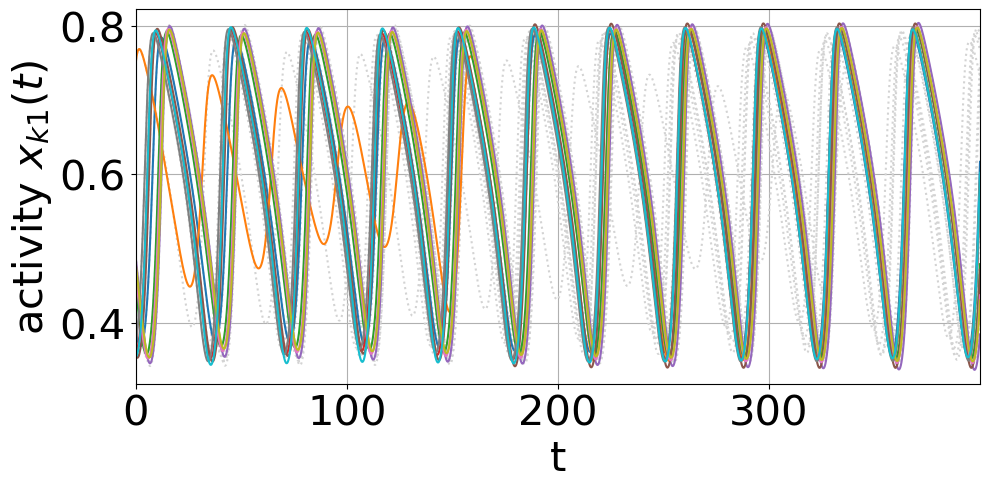

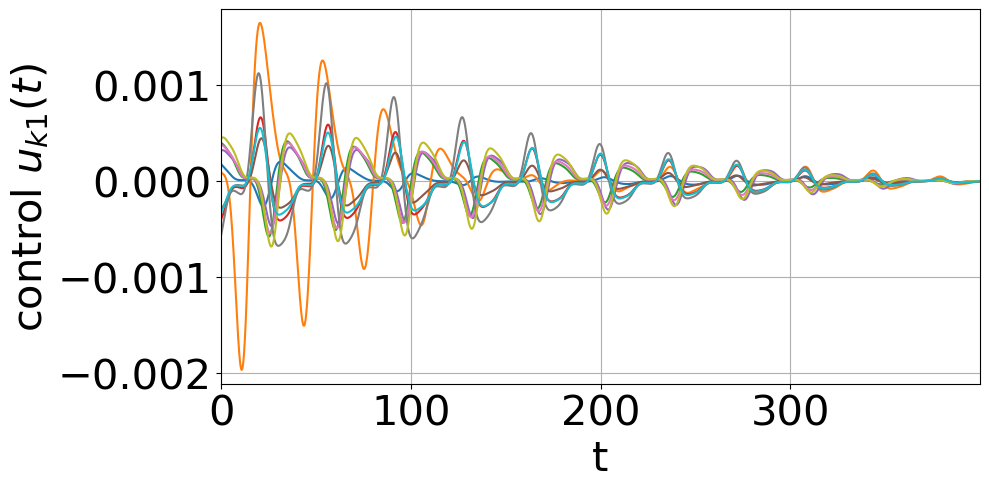

In [45]:
######################### PLOT THE RESULTS ############################


import matplotlib.pyplot as plt
from pylab import figure, cm


#calculate the controlled and uncontrolled state
control=control.reshape(tsteps,parameters['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control.detach(), **args)
nocontrol=torch.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

#make plot
fs=30 #fontsize
i=-1
# PLOT NETWORK STATE
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=torch.min(state_controlled[:,0,:])
maxx=torch.max(state_controlled[:,0,:])
add=(maxx-minn)/25
im1=ax.plot(torch.arange(0,int(T),dt),state_uncontrolled[:,0,:],color='lightgray',linestyle='dotted')
ax.plot(torch.arange(0,int(T),dt),state_controlled[:,0,:])
ax.set_xlabel('t',size=fs)
ax.set_ylabel('activity $x_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Network state',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()


# PLOT CORRESPONDING OPTIMAL CONTROL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=torch.min(control.detach())
maxx=torch.max(control.detach())
add=(maxx-minn)/25

im1=ax.plot(torch.arange(0,int(T),dt),control.detach())
ax.set_xlabel('t',size=fs)
ax.set_ylabel('control $u_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Control',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()




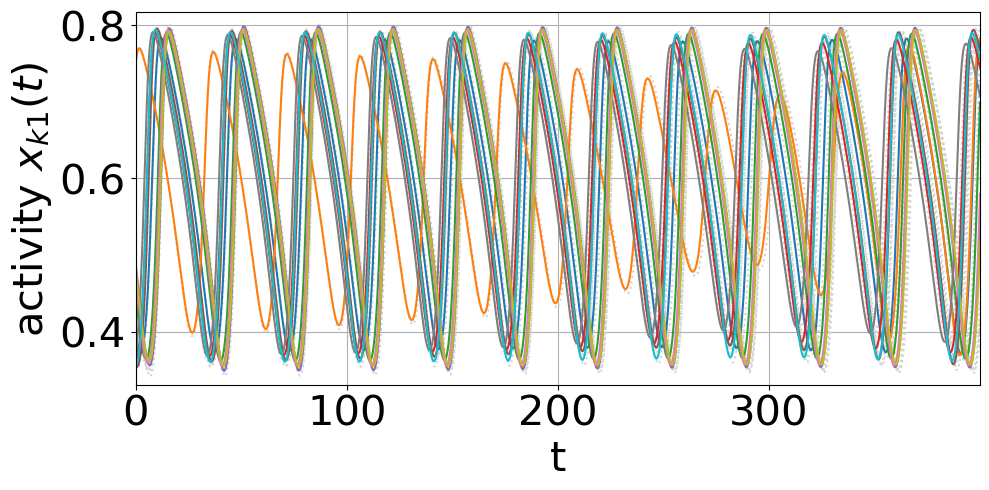

/var/folders/rr/j6h778k96l3cmvkjn2gmtjt40000gn/T/ipykernel_38629/793847194.py:49: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(minn-add,maxx+add)


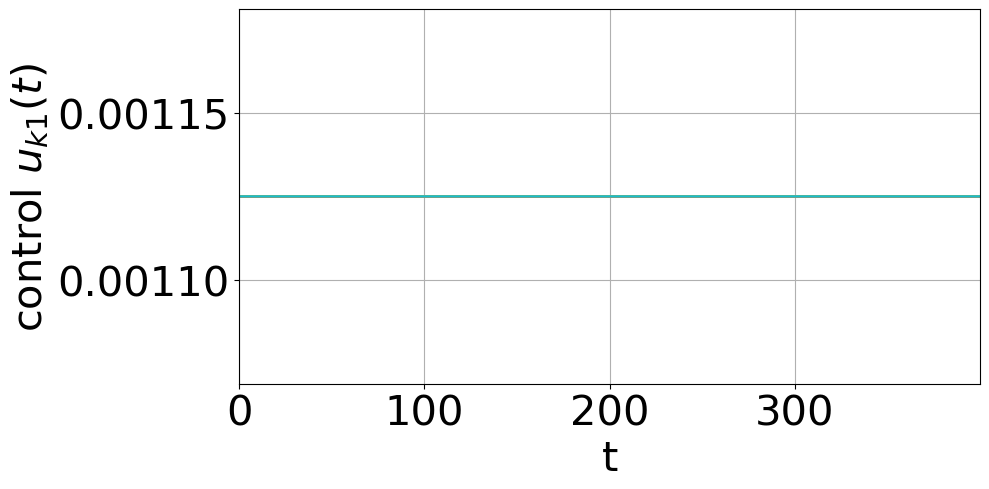

In [39]:
######################### PLOT THE RESULTS ############################


import matplotlib.pyplot as plt
from pylab import figure, cm


#calculate the controlled and uncontrolled state
control=control.reshape(tsteps,parameters['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control.detach(), **args)
nocontrol=torch.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

#make plot
fs=30 #fontsize
i=-1
# PLOT NETWORK STATE
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=torch.min(state_controlled[:,0,:])
maxx=torch.max(state_controlled[:,0,:])
add=(maxx-minn)/25
im1=ax.plot(torch.arange(0,int(T),dt),state_uncontrolled[:,0,:],color='lightgray',linestyle='dotted')
ax.plot(torch.arange(0,int(T),dt),state_controlled[:,0,:])
ax.set_xlabel('t',size=fs)
ax.set_ylabel('activity $x_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Network state',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()


# PLOT CORRESPONDING OPTIMAL CONTROL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=torch.min(control.detach())
maxx=torch.max(control.detach())
add=(maxx-minn)/25

im1=ax.plot(torch.arange(0,int(T),dt),control.detach())
ax.set_xlabel('t',size=fs)
ax.set_ylabel('control $u_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Control',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()


